In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.colors import LogNorm
import tarfile
import math
from numba import jit

from discretize import TreeMesh
from discretize.utils import mkvc, active_from_xyz, refine_tree_xyz

from SimPEG.utils import model_builder
from SimPEG import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static import utils as dc_utils
from SimPEG.electromagnetics.static import induced_polarization as ip
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

from matplotlib.patches import Circle

mpl.rcParams.update({"font.size": 10})
#plt.rcParams["font.family"] = "Arial"

In [3]:
x_topo, y_topo = np.meshgrid(
    np.linspace(-100, 100, 201), np.linspace(-100, 100, 201)
)
z_topo = 0 * x_topo
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

# Create 2D topography. Since our 3D topography only changes in the x direction,
# it is easy to define the 2D topography projected along the survey line. For
# arbitrary topography and for an arbitrary survey orientation, the user must
# define the 2D topography along the survey line.
topo_2d = np.unique(topo_xyz[:, [0, 2]], axis=0)

In [4]:
# Generate source list for IP survey line
ip_data_type = "apparent_chargeability"
survey_type = "dipole-dipole"
dimension_type = "2D"
end_locations = np.r_[-20.0, 20.0]
station_separation = 1.0
num_rx_per_src = 40

source_list = generate_dcip_sources_line(
    survey_type,
    ip_data_type,
    dimension_type,
    end_locations,
    topo_xyz,
    num_rx_per_src,
    station_separation,
)

# Define survey
ip_survey = ip.survey.Survey(source_list, survey_type=survey_type)

C:\Users\dwill\Documents\Projects\SOLA\simpeg\simpeg\electromagnetics\static\resistivity\survey.py:32: FutureWarning: Argument 'survey_type' is ignored and will be removed in future versions of SimPEG. Types of sources and their corresponding receivers are obtained from their respective classes, without the need to specify the survey type.
  warnings.warn(


In [6]:
dh = 0.1  # base cell width
dom_width_x = 100.0  # domain width x
dom_width_z = 30.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Refine core mesh region
mesh.refine_box([-30, -12], [30, 0.0], -1, finalize=False)

mesh.finalize()

C:\Users\dwill\AppData\Local\Temp\ipykernel_38272\1653216006.py:10: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  mesh = TreeMesh([hx, hz], x0="CN")


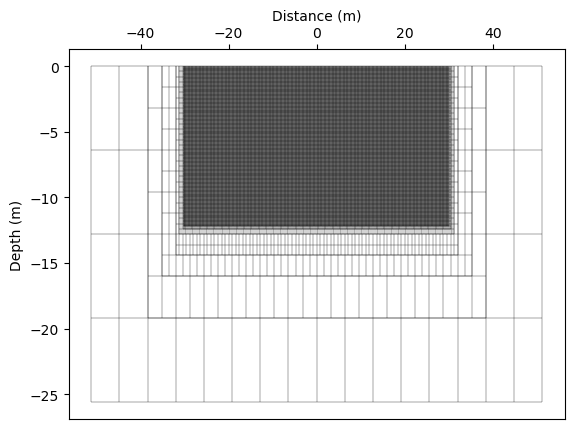

In [7]:
ax = mesh.plot_grid(linewidth=0.25, color='black')
plt.grid(False)
#ax.set_xlim([-20,20])
ax.set_xlabel('Distance (m)', loc='center')
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.savefig('toy_grid_model.png', dpi=300)

In [8]:
# Define conductivity model in S/m 
air_conductivity = 1e-8
background_conductivity = 1e-2

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum())
conductivity_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define model
conductivity_model = background_conductivity * np.ones(nC)

(81, 405)


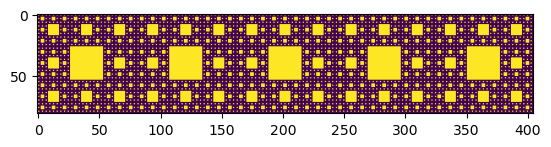

In [10]:
##
# Sierpinsky carpet
# importing necessary modules 
import numpy as np 
from PIL import Image 
  
# total number of times the process will be repeated 
total = 4
  
# size of the image 
size = 3**total 
  
# creating an image 
square = np.empty([size, size]) 
 
# filling it black 
square.fill(0) 
  
for i in range(0, total + 1): 
    stepdown = 3**(total - i) 
    for x in range(0, 3**i):           
        # checking for the centremost square 
        if x % 3 == 1: 
            for y in range(0, 3**i): 
                if y % 3 == 1:                      
                    # changing its color 
                    square[y * stepdown:(y + 1)*stepdown, x * stepdown:(x + 1)*stepdown] = 0.2 

square2 = np.c_[square, square, square, square, square]
print(square2.shape)
fig, ax = plt.subplots()
ax.imshow(square2)
plt.show()

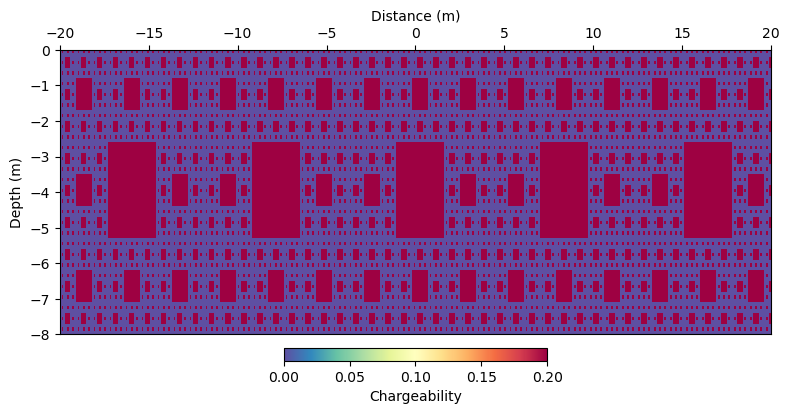

In [13]:
# Define chargeability model as intrinsic chargeability.
air_chargeability = 0.0
background_chargeability = 1e-6
sphere_chargeability = 0.2

# Find active cells in forward modeling (cells below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum())
chargeability_map = maps.InjectActiveCells(mesh, ind_active, air_chargeability)

# Define chargeability model
chargeability_model = background_chargeability * np.ones(nC)

# Block 1
block1_coords = [np.r_[-20.0, -2.0], np.r_[-15, -1.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[-20.0, -2.0], np.r_[-15, -1.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

# Block 2
block2_coords = [np.r_[-10.0, -3.0], np.r_[-5, -1.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[-10.0, -3.0], np.r_[-5, -1.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

# Block 3
block3_coords = [np.r_[0.0, -4.0], np.r_[5, -2.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[0.0, -4.0], np.r_[5, -2.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

# Block 4
block4_coords = [np.r_[10.0, -5.0], np.r_[15, -2.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[10.0, -5.0], np.r_[15, -2.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

# Block 5
block5_coords = [np.r_[20.0, -7.0], np.r_[25, -4.0]]
ind_chargeable = model_builder.get_indices_block(
    np.r_[20.0, -7.0], np.r_[25, -4.0], mesh.gridCC
)
chargeability_model[ind_chargeable] = sphere_chargeability

##
# 
sq_nz, sq_nx = square2.shape
xmin = -20; xmax = 20
zmin = -8; zmax = 0
chargeability_model[:] = 0
cell_centers = mesh.cell_centers
nC = mesh.nC
nC = mesh.nC
for i in range(nC):
    xc = cell_centers[i,0]
    zc = cell_centers[i,1]
    if xc > xmin and xc < xmax:
        if zc > zmin and zc < zmax:
            ix = int((xc-xmin)/dh)
            iz = int((zc-zmin)/dh)
            if (ix < sq_nx) and (iz < sq_nz):
                chargeability_model[i] = square2[iz,ix]
                
# Plot Chargeability Model
fig, ax = plt.subplots(1, 1, figsize=(8,6))
charge_true = chargeability_map*chargeability_model
charge_true[~ind_active] = np.nan
out = mesh.plot_image(charge_true, normal="Y",
                      ax=ax, clim = (0,0.2),
                      grid=False, pcolor_opts={"cmap": "Spectral_r"})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal',                   
                  ax=ax, pad=0.025)
cb.set_label("Chargeability")

#ax.set_title("True Chargeability Model")
ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_aspect(2.0)  # some vertical exxageration
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.tight_layout()

plt.savefig('toy_model.png', dpi=300, bbox_inches='tight')

plt.show()

In [14]:
air_chargeability = 0.0
chargeability_map = maps.InjectActiveCells(mesh, ind_active, air_chargeability)

ip_simulation = ip.Simulation2DNodal(mesh,
    survey=ip_survey,
    etaMap=chargeability_map,
    sigma=conductivity_map * conductivity_model,
    solver=Solver,
    storeJ=True,
) 

In [15]:
# Run forward simulation and predicted IP data. The data are the voltage (V)
dpred_ip = ip_simulation.dpred(chargeability_model)

C:\Users\dwill\.conda\envs\simpeg-dev\Lib\site-packages\pymatsolver\solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


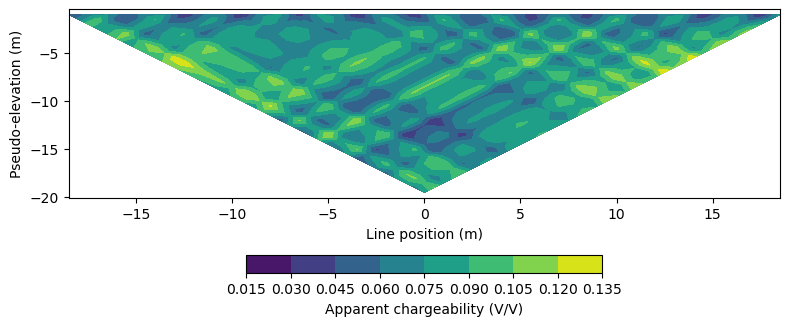

In [16]:
# Plot apparent chargeability
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
ax = dc_utils.plot_pseudosection(
    ip_survey,
    dpred_ip,
    "contourf",
    ax=ax1,
    scale="linear",
    cbar_label="Apparent chargeability (V/V)",
    create_colorbar=False,
)

ax[0].set_aspect(0.5)
fig.colorbar(ax[1], orientation='horizontal', shrink=0.5, pad=0.1, label='Apparent chargeability (V/V)')
plt.tight_layout()

plt.savefig('toy_data.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
class SOLA:
    def __init__(self, dobs, dobs_err, mesh, G, ind_active=[]):
        """
        Parameters
        ----------
        dobs :
            Observed data.
        dobs_err :
            Data standard deviations.
        mesh :
            Modeling mesh.
        G :
            Sensitivity matrix.
        """

        self.G = G.copy()
        self.mesh = mesh
        self.dobs = dobs.copy()
        self.dobs_err = dobs_err.copy()
        
        self.N, self.M = np.shape(G)
        if len(ind_active) > 0:
            self.v_cells = mesh.cell_volumes[ind_active]
        else:
            self.v_cells = mesh.cell_volumes

        # Scale by the data error
        #  data
        self.dobs = np.divide(self.dobs, self.dobs_err)
        #  sensitivity matrix
        for j in range(self.M):
            self.G[:,j] = np.divide(self.G[:,j], self.dobs_err)
        
        self.G_hat = np.zeros((self.N, self.M))
        for j in range(self.M):
            self.G_hat[:, j] = self.G[:, j] / math.sqrt(self.v_cells[j])

        # create vector c_hat
        self.c_1 = np.sum(self.G[0, :])
        self.c_hat = np.zeros((self.N - 1, 1))
        for i in range(1, self.N):
            c_i = np.sum(self.G[i, :])
            self.c_hat[i-1] = c_i / self.c_1

    """
        Auxiliary functions.
    """

    def set_tradeoff_value(self, eta):
        """Set value for the resolution-error tradeoff parameter."""
        self.eta = eta

        self.I_Nminus1 = np.identity(self.N - 1)
        self.B = np.vstack((-self.c_hat.T, self.I_Nminus1))
        Ghat_tB = np.matmul(self.G_hat.T, self.B)
        self.Q_eta = np.vstack((Ghat_tB, -eta * self.c_hat.T))

    def run(self, T, avgA=False, eta_changed=True):
        """Run SOLA inversion.

        Parameters
        ----------
        r0 : list
            Coordinates of the analysis point.
        T :
            Target kernel.
        AvgA : bool
            If True, also returns the computed averaging kernel.

        """
       
        t_k = np.reshape(np.sqrt(self.v_cells) * T, (self.M, 1))

        # Set rhs y(k,eta)
        e_1 = np.zeros((self.N, 1))
        e_1[0] = 1
        f1 = t_k - (1 / self.c_1) * np.matmul(self.G_hat.T, e_1)
        f2 = -(1 / self.c_1) * self.eta
        y_k_eta = np.vstack((f1, f2))

        # Finally assemble LSQR system
        Zeros_Nminus1 = np.zeros((self.N - 1, 1))
        if eta_changed:
            self.S = np.vstack((self.Q_eta, self.eta * self.I_Nminus1))
            self.S_inv = np.linalg.pinv(self.S)
            
        y = np.vstack((y_k_eta, Zeros_Nminus1))

        ###############################
        # Solve the SOLA linear system
        ###############################

        #try:
        #    res = np.linalg.lstsq(self.S, y, rcond=None)
        #    x_est = res[0]
        #except:
        #    print("ERROR: lstsq did not converge!") 
        x_est = self.S_inv @ y
        
        # Last steps to complete the solution x_k
        x_hat_k = np.reshape(x_est, (self.N - 1, 1))
        x_k = np.matmul(self.B, x_hat_k) + (1 / self.c_1) * e_1

        # Compute average estimate and variance
        x_est = 0
        x_var = 0
        for i in range(self.N):
            x_est = x_est + x_k[i] * self.dobs[i]
            x_var = x_var + x_k[i]**2

        x_err = np.sqrt(x_var)

        if avgA:
            # Averaging kernel
            A_k = np.zeros((self.M, 1))
            for i in range(self.N):
                A_k[:, 0] = A_k[:, 0] + x_k[i] * self.G[i, :]

            A_k[:, 0] = np.divide(A_k[:, 0], self.v_cells)

            # Compute unimodularity constraint
            uc = 0
            for j in range(self.M):
                uc = uc + A_k[j] * self.v_cells[j]

            return x_est, x_err, A_k, uc
        else:
            return x_est, x_err

In [18]:
def disk_target_kernel(r0, radius, mesh, ind_active=[]):
    xmin = -20.
    xmax = 20.
    zmin = -8.
    zmax = 0.
    
    v_cells = mesh.cell_volumes
    cell_centers = mesh.cell_centers
    ncells = len(v_cells)
    T = np.zeros(ncells)

    x0 = r0[0]
    z0 = r0[1]

    # Define region around r0 with.
    xblim = np.c_[x0 - 1.5 * radius, x0 + 1.5 * radius]
    zblim = np.c_[z0 - 1.5 * radius, z0 + 1.5 * radius]
    
    # Set kernel values
    c = 0
    for i in range(ncells):
        xc = cell_centers[i, 0]
        zc = cell_centers[i, 1]
        if (np.sqrt((xc - x0) ** 2 + (zc - z0) ** 2)) <= radius:
            if len(ind_active) > 0:
                if ind_active[i]:
                    T[i] = 1
                    c = c + v_cells[i]
            else:
                T[i] = 1
                c = c + v_cells[i]

    # Normalize T
    T = T/c

    if len(ind_active) > 0:
        T_active = T[ind_active]
    else:
        T_active = T

    return T_active

In [19]:
from matplotlib.patches import Circle
def plot_Ak(Ak, r0, s0=None, title='', text_loc=None, text=None, ax=None, xlim=None, ylim=None):
    n = len(Ak)
    Ak_n = np.zeros(Ak[0].size)
    for a in Ak:
        t = np.divide(a, np.max(abs(a)))
        Ak_n = Ak_n + t
        
    #Ak[np.where(abs(Ak)<0.04)] = np.NaN
    sola_Ak = np.zeros(len(mesh))
    sola_Ak[ind_active] = Ak_n
    sola_Ak[~ind_active] = np.nan
    
    out = mesh.plot_image(sola_Ak, ax=ax,
                          clim=(-1,1),
                          pcolor_opts={"cmap": mpl.cm.bwr},
                          grid=False)
    cb = plt.colorbar(out[0], fraction=0.025,
                      orientation='horizontal',
                      ticks=[-1, 0, 1],
                      ax=ax, pad=0.025)
    
    cb.ax.set_xticklabels(['-1.0', '0', '1.0'])

    #ax.set_title(title)
    #ax.set_xlim(-20, 20)
    #ax.set_ylim(-8, 0)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect(1)#(2.0)  
    ax.set_xlabel('Distance (m)', loc='center')
    ax.set_ylabel('Depth (m)')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')

    for i in range(n):
        r = r0[i]
        s = s0[i]
        circle_patch = Circle(r, s, color='k', fill=False)
        ax.add_patch(circle_patch)

    #circle_patch = Circle(r0, 0.25, color='lime', fill=True)
    #ax.add_patch(circle_patch)

    #plot_blocks(ax)  
   

    if text_loc is not None:
        ax.text(text_loc[0], text_loc[1], text)
    
    #plt.savefig('figure.png', dpi=600, bbox_inches='tight')
    plt.savefig('figure.png', transparent=True, dpi=600, bbox_inches='tight')
    
    plt.tight_layout()
    return ax   

# Setup data for inversions

Setup inversions

In [20]:
##
# Observations
nobs = len(dpred_ip)
noise_floor = 0.001
std = 0.05 * np.abs(dpred_ip)
std[np.where(std<noise_floor)] = noise_floor
d_err = std
ip_noise = std * np.random.normal(size=len(dpred_ip))
d_obs = dpred_ip + ip_noise

## Setup the sensitivity matrix 
G = ip_simulation.getJ(chargeability_model).copy()
N, M = np.shape(G)
scale = np.reshape(ip_simulation._scale, (N, 1))
for i in range(N):
    G[i,:] = scale[i]*G[i,:]

v_cells = mesh.cell_volumes[ind_active]

C:\Users\dwill\AppData\Local\Temp\ipykernel_38272\2477084100.py:3: UserWarning: plot_pseudosection unused kwargs: ['data_location']
  ax = dc_utils.plot_pseudosection(


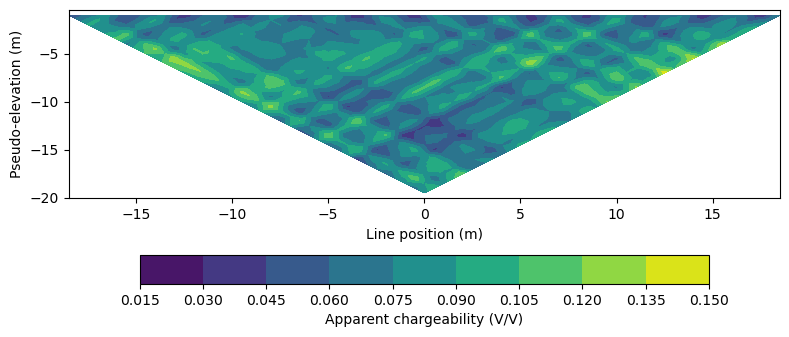

In [21]:
# Plot apparent chargeability
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
ax = dc_utils.plot_pseudosection(
    ip_survey,
    d_obs,
    "contourf",
    ax=ax1,
    data_location=True,
    cbar_label="Apparent chargeability (V/V)",
    create_colorbar=False,
)

ax[0].set_aspect(0.5)
fig.colorbar(ax[1], orientation='horizontal', shrink=0.8, pad=0.1, label='Apparent chargeability (V/V)')
plt.tight_layout()

plt.savefig('toy_data_noise.png', dpi=300, bbox_inches='tight')
plt.show()

# SOLA analysis

In [28]:
sola_inv = SOLA(d_obs, d_err, mesh, G, ind_active)

### Plot normalized sensitivity

In [23]:
den = np.max(np.sum(abs(G), 0))
D = np.sum(abs(G), 0)/den
D = np.log10(D)
rho_k = D[10]

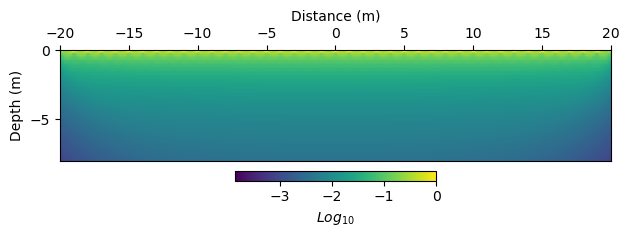

In [24]:
D_plot = np.zeros(len(mesh))
D_plot[ind_active] = D
D_plot[~ind_active] = np.nan
    
fig, ax = plt.subplots(1, 1)
out = mesh.plot_image(D_plot, ax=ax,
                      pcolor_opts={"cmap": mpl.colormaps['viridis']},
                      grid=False)
cb = plt.colorbar(out[0], fraction=0.025,
                  orientation='horizontal',
                  #ticks=[-1, 0, 1],
                  ax=ax, pad=0.025)
cb.ax.set_xlabel('$Log_{10}$')    
#cb.ax.set_xticklabels(['-1.0', '0', '1.0'])

#ax.set_title(title)
ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_aspect(2.0)  
ax.set_xlabel('Distance (m)', loc='center')
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

#plot_blocks(ax)

ax.set_aspect(1)
plt.tight_layout()

#plt.savefig('figure.png', dpi=600, bbox_inches='tight')
plt.savefig('toy_norm_sens.png', dpi=600, bbox_inches='tight')

### Plot rows of the sensitivity matrix

C:\Users\dwill\AppData\Local\Temp\ipykernel_38272\1173565190.py:18: RuntimeWarning: invalid value encountered in log10
  r1 = np.log10(G[irow[0],:])
C:\Users\dwill\AppData\Local\Temp\ipykernel_38272\1173565190.py:19: RuntimeWarning: invalid value encountered in log10
  r2 = np.log10(G[irow[1],:])
C:\Users\dwill\AppData\Local\Temp\ipykernel_38272\1173565190.py:20: RuntimeWarning: invalid value encountered in log10
  r3 = np.log10(G[irow[2],:])
C:\Users\dwill\AppData\Local\Temp\ipykernel_38272\1173565190.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


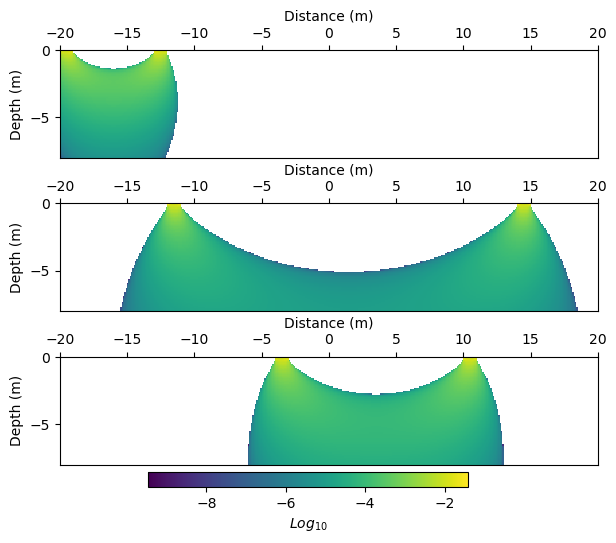

In [25]:
def plot_srow(r, ax):
    im = mesh.plot_image(r, ax=ax, pcolor_opts={"cmap": mpl.colormaps['viridis']}, grid=False)   
    ax.set_xlim(-20, 20)
    ax.set_ylim(-8, 0)
    ax.set_aspect(2.0)  
    ax.set_xlabel('Distance (m)', loc='center')
    ax.set_ylabel('Depth (m)')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.set_aspect(1)
    return im

xc = 0 
zc = -1. 
r0 = np.r_[xc, zc]
#k = mesh.closest_points_index(r0, 'cell_centers')
irow = [5, 300, 500]
r1 = np.log10(G[irow[0],:])
r2 = np.log10(G[irow[1],:])
r3 = np.log10(G[irow[2],:])

fig, ax = plt.subplots(3, 1)

plot_srow(r1, ax[0])
plot_srow(r2, ax[1])
im = plot_srow(r3, ax[2])

cbar_ax = fig.add_axes([0.25, -0.015, 0.5, 0.03])
cb = fig.colorbar(im[0], fraction=0.1,
                  orientation='horizontal',
                  #ticks=[-1, 0, 1],
                  cax=cbar_ax)
cb.ax.set_xlabel('$Log_{10}$')    

plt.tight_layout()

plt.savefig('toy_sens_rows.png', dpi=300, bbox_inches='tight')

## Create panel of averaging kernels

avgtrue:  0.20000000000000007 mk_est:  [-0.18029774] ; mk_err:  [0.39721442] ; mk_err % of true value:  [190.14886862] ; mk_err %:  [-220.31026328]
Ak bias:  [1.]
avgtrue:  0.20000000000000007 mk_est:  [0.10892797] ; mk_err:  [0.01672612] ; mk_err % of true value:  [45.53601534] ; mk_err %:  [15.35520997]
Ak bias:  [1.]
avgtrue:  0.20000000000000007 mk_est:  [0.10326998] ; mk_err:  [0.01201623] ; mk_err % of true value:  [48.365008] ; mk_err %:  [11.63574212]
Ak bias:  [1.]
avgtrue:  0.12249999999999991 mk_est:  [-0.02110675] ; mk_err:  [0.14434237] ; mk_err % of true value:  [117.23000382] ; mk_err %:  [-683.86813358]
Ak bias:  [1.]
avgtrue:  0.12249999999999991 mk_est:  [0.09792286] ; mk_err:  [0.01036899] ; mk_err % of true value:  [20.06297427] ; mk_err %:  [10.58893595]
Ak bias:  [1.]
avgtrue:  0.12249999999999991 mk_est:  [0.09464833] ; mk_err:  [0.00805272] ; mk_err % of true value:  [22.7360588] ; mk_err %:  [8.50804737]
Ak bias:  [1.]
avgtrue:  0.0647798742138373 mk_est:  [0.0

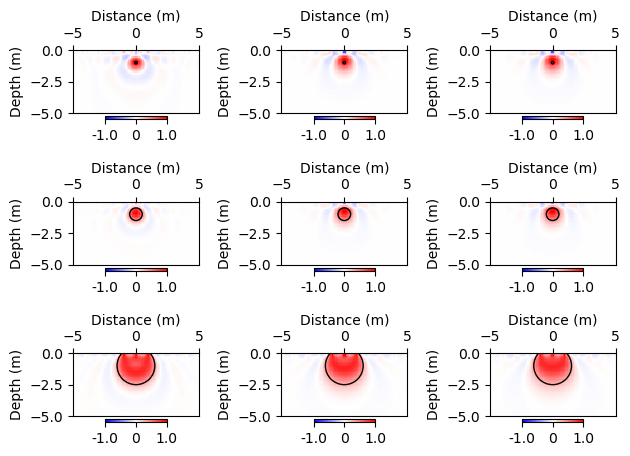

In [29]:
xc = 0 
zc = -1. 
r0 = np.r_[xc, zc]
s = np.r_[0.1,0.5,1.5]
eta = np.r_[1,20,30]
def run_inv(s, n):
    rmax = s
    T = disk_target_kernel(r0, s, mesh, ind_active)
    avg_true = (dh**2)*np.dot(T, charge_true)
    sola_inv.set_tradeoff_value(n)
    mk, mk_err, Ak, uc = sola_inv.run(T, avgA=True)
    print("avgtrue: ", avg_true, "mk_est: ", mk, "; mk_err: ", mk_err, 
          "; mk_err % of true value: ", abs(mk - avg_true)/avg_true*100,
          "; mk_err %: ", mk_err/mk*100)
    print('Ak bias: ', uc)
    return Ak

Ak1 = run_inv(s[0], eta[0])
Ak2 = run_inv(s[0], eta[1])
Ak3 = run_inv(s[0], eta[2])
Ak4 = run_inv(s[1], eta[0])
Ak5 = run_inv(s[1], eta[1])
Ak6 = run_inv(s[1], eta[2])
Ak7 = run_inv(s[2], eta[0])
Ak8 = run_inv(s[2], eta[1])
Ak9 = run_inv(s[2], eta[2])

fig, ax = plt.subplots(3,3)

ax1 = plot_Ak([Ak1[:,0]], [r0], [s[0]], ax=ax[0,0], xlim=[-5,5], ylim=[-5,0])
ax2 = plot_Ak([Ak2[:,0]], [r0], [s[0]], ax=ax[0,1], xlim=[-5,5], ylim=[-5,0])
ax3 = plot_Ak([Ak3[:,0]], [r0], [s[0]], ax=ax[0,2], xlim=[-5,5], ylim=[-5,0])

ax4 = plot_Ak([Ak4[:,0]], [r0], [s[1]], ax=ax[1,0], xlim=[-5,5], ylim=[-5,0])
ax5 = plot_Ak([Ak5[:,0]], [r0], [s[1]], ax=ax[1,1], xlim=[-5,5], ylim=[-5,0])
ax6 = plot_Ak([Ak6[:,0]], [r0], [s[1]], ax=ax[1,2], xlim=[-5,5], ylim=[-5,0])

ax7 = plot_Ak([Ak7[:,0]], [r0], [s[2]], ax=ax[2,0], xlim=[-5,5], ylim=[-5,0])
ax8 = plot_Ak([Ak8[:,0]], [r0], [s[2]], ax=ax[2,1], xlim=[-5,5], ylim=[-5,0])
ax9 = plot_Ak([Ak9[:,0]], [r0], [s[2]], ax=ax[2,2], xlim=[-5,5], ylim=[-5,0])

plt.tight_layout()

plt.savefig('toy_kernels.png', dpi=300, bbox_inches='tight')

## Inversion all domain

### Create grid for inversion

In [30]:
##
# Define grid for inversion
dh_inv = 0.5  # base cell width
dom_width_x = 100.0  # domain width x
dom_width_z = 30.0  # domain width z
nbcx_inv = 2 ** int(np.round(np.log(dom_width_x / dh_inv) / np.log(2.0)))  # num. base cells x
nbcz_inv = 2 ** int(np.round(np.log(dom_width_z / dh_inv) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx_inv = [(dh_inv, nbcx_inv)]
hz_inv = [(dh_inv, nbcz_inv)]
mesh_inv = TreeMesh([hx_inv, hz_inv], x0="CN")

# Refine core mesh region
mesh_inv.refine_box([-30, -12], [30, 0.0], -1, finalize=False)
mesh_inv.finalize()

C:\Users\dwill\AppData\Local\Temp\ipykernel_38272\121590098.py:12: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you havepreviously created. If you need to keep the current behavoir, explicitly set diagonal_balance=False.
  mesh_inv = TreeMesh([hx_inv, hz_inv], x0="CN")


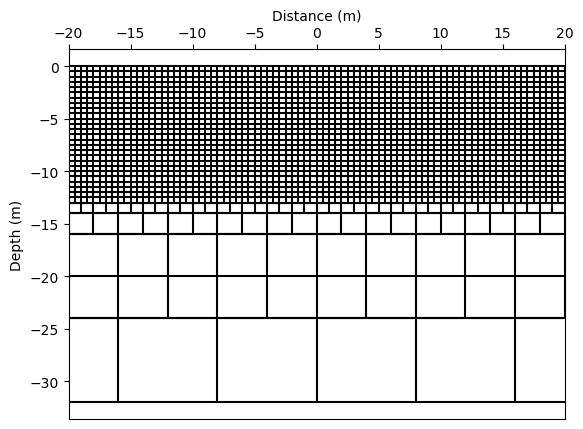

In [31]:
ax = mesh_inv.plot_grid(color='black')
plt.grid(False)
ax.set_xlim([-20,20])
ax.set_xlabel('Distance (m)', loc='center')
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.savefig('toy_grid_inv.png', dpi=300)

In [32]:
##
# Find the total number of cells in the region of interest.
cell_centers = mesh_inv.cell_centers
nC = mesh_inv.nC

# Define the limits of the region of interest for the inversion
xmin = -20; xmax = 20
zmin = -8; zmax = 0

nc_total = 0
for i in range(nC):
    xc = cell_centers[i,0]
    zc = cell_centers[i,1]
    if xc > xmin and xc < xmax:
        if zc > zmin and zc < zmax:
            nc_total = nc_total + 1

In [33]:
##
# Compute Dsorted wich contains the sorted cells indices  based
# on their respective normalized sensitivity values.

cell_centers = mesh_inv.gridCC
nC = mesh_inv.nC
D_inv = np.zeros(nC)
for i in range(nC):
    xc = cell_centers[i,0]
    zc = cell_centers[i,1]
    r0 = np.r_[xc, zc]
    k = mesh.closest_points_index(r0, 'cell_centers')
    k = k[0]
    D_inv[i] = D[k]
    
Dsorted_ind = np.argsort(D_inv)

## Run the inversion

In [34]:
%%time
cell_centers = mesh_inv.cell_centers
nC = mesh_inv.nC

rmin = 0.5
rmax = 2.5
eta_min = 1.
eta_max = 10.

k1 = mesh.closest_points_index([0, -0.5], 'cell_centers')
k2 = mesh.closest_points_index([0, -8], 'cell_centers')
k1 = k1[0]
k2 = k2[0]
rho_min = D[k2]
rho_max = D[k1]

Dsorted_ind = np.argsort(D_inv)

xmin = -20; xmax = 20
zmin = -8; zmax = 0

mk_2 = np.zeros(nC)
merr_2 = np.zeros(nC)
kernel_sizes = np.zeros(nC)

eta = 0.
nc_proc = 0
for i in range(nC):
    k = Dsorted_ind[i] 
    xc = cell_centers[k,0]
    zc = cell_centers[k,1]
    if xc > xmin and xc < xmax:
        if zc > zmin and zc < zmax:
            r0 = np.r_[xc, zc]
            # Set target kernel size
            #k = mesh.closest_points_index(r0, 'cell_centers')
            #k = k[0]
            rho = D_inv[k]
            if rho > rho_max:
                rho = rho_max
            if rho < rho_min:
                rho = rho_min
            s = rmax - (rmax - rmin)*((rho - rho_min)/(rho_max - rho_min)) 
            kernel_sizes[k] = s
            T = disk_target_kernel(r0, s, mesh, ind_active)
            
            eta_t = eta_max - (eta_max - eta_min)*(1 - (rho - rho_min)/(rho_max - rho_min))      
            eta_f = False
            if eta > 0:
                eta_diff = abs(eta_t-eta)/eta
            else:
                eta_diff = 1.
            
            if eta_diff > 0.1:
                eta = eta_t
                sola_inv.set_tradeoff_value(eta)
                eta_f = True

            nc_proc = nc_proc + 1
            nc_perc = nc_proc/nc_total * 100
            print(f"cell being processed: {nc_proc}/{nc_total} [{nc_perc:.2f}%] p:[{xc:.2f},{zc:.2f}] [{eta:.2f}]", end='\r')
            mk_2[k], merr_2[k] = sola_inv.run(T, avgA=False, eta_changed=eta_f) 
           

cell being processed: 1/1280 [0.08%] p:[-19.75,-7.75] [1.00]

<timed exec>:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


CPU times: total: 27min 37s
Wall time: 16min 42s
25,-0.25] [9.30]

In [37]:
##
# Save inversion model, and error
np.save('mk.npy', mk_2)
np.save('merr.npy', merr_2)

## Plot inversion output

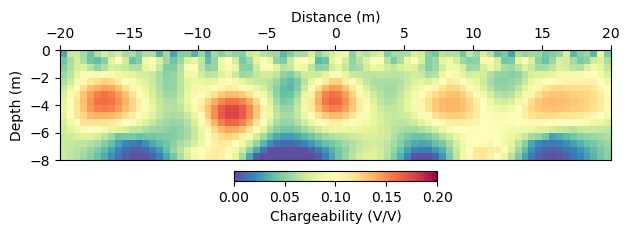

In [41]:
fig, ax = plt.subplots()
eta = mk_2
out = mesh_inv.plot_image(eta, normal="Y",
                          ax=ax, clim = (0,0.2),
                          grid=False, pcolor_opts={"cmap": "Spectral_r"})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label("Chargeability (V/V)")

ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_yticks([0, -2, -4, -6, -8])
ax.set_aspect(1.0)
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.savefig('ip-synth_sol.png', dpi=300, bbox_inches='tight')

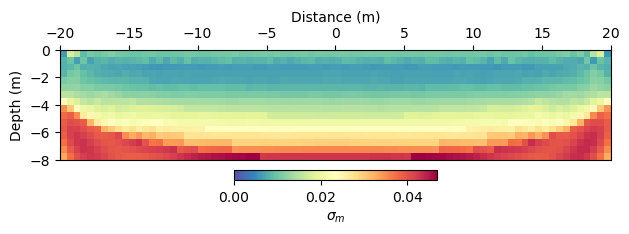

In [38]:
merr = np.load('merr.npy')
fig, ax = plt.subplots()
#eta[np.where(merr_2>0.035)] = np.nan
out = mesh_inv.plot_image(merr, normal="Y",
                          ax=ax,
                          grid=False, pcolor_opts={"cmap": "Spectral_r"})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label("$\sigma_m$")

ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_yticks([0, -2, -4, -6, -8])
ax.set_aspect(1.0)
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.savefig('ip-synth_err.png', dpi=300, bbox_inches='tight')

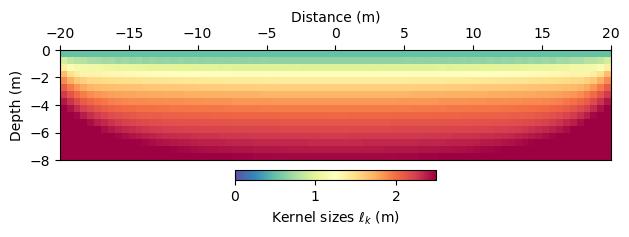

In [39]:
ks = kernel_sizes
fig, ax = plt.subplots()
#eta[np.where(merr_2>0.035)] = np.nan
out = mesh_inv.plot_image(ks, normal="Y",
                          ax=ax,
                          grid=False, pcolor_opts={"cmap": "Spectral_r"})
cb = plt.colorbar(out[0], fraction=0.025, 
                  orientation='horizontal', 
                  ax=ax, pad=0.025)
cb.set_label("Kernel sizes $\ell_k$ (m)")

ax.set_xlim(-20, 20)
ax.set_ylim(-8, 0)
ax.set_yticks([0, -2, -4, -6, -8])
ax.set_aspect(1.0)
ax.set_xlabel('Distance (m)', loc = "center")
ax.set_ylabel('Depth (m)')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.tight_layout()
plt.savefig('ip-synth_ks.png', dpi=300, bbox_inches='tight')